$$ \Large{\textbf{Digital Signal Processing and Deep Learning:  Environment Sound Classification }} $$   
$$ \large{\textbf{Part III: Complex Wavelet Transforms + Mel-Spectrograms and Convolutional Neural Network}} $$

$$ \small{\textbf{Dr. Stéphane DEDIEU, Dec. 2022 - Jan. 2023 }} $$

# Introduction

<span style="color:#4169E1">  Automatic environmental sound classification (ESC) based on ESC-10 dataset subset.
<br>
In this notebook we propose a "fusion" of complex wavelet transforms (in Part II) and mel-spectrograms (in Part I) for getting rid of last "residual" confusions in Part II (complex wavelets only). <br>
Again, like in Part II, we select different types of complex wavelets for different types of sounds/noise. The selection is not automatic at the moment. We are just testing the principle. <br>
After training a Convolutionnal Neural Network with 3 series of 128x128 grayscale images: scalograms magnitude, scalograms phase, mel-spectrograms, <b>maximum accuracy= 99 %. </b> <br> 
<br> 

# Methodology
<br>
<span style="color:#4169E1"> 

- Methodology is similar to Part I + Part II. 
- We compute 128x128 mel-spectrograms and 128x128 complex CWT, for all audio clips.  
- We train the CNN with 3 series of 128x128 grayscale images: scalograms magnitude, scalograms phase, mel-spectrograms. 

#  Results

<span style="color:#4169E1">  The notebook is pretty long. We present results and conclusions here.  <br>
Details about methodology, wavelet selection, hyperparameters of the Convolutional Neural Network are provided in context. <br> 
<b>With the methodology presented in this notebook, accuracy is between 96 to 99%. </b><br>
One of the best results is presented below.     

|<p align="center">   <img src="Fusion_Wavelet_Phase_Classification_99pc.png"  width="350"  /> </p> | <p align="center"> <img src="Fusion_Wavelet_Phase_ConfusionMatrix_99pc.png" width="300"  /> </p> |  
| ---       | ---       |   
|<p align="center"> <b><i> Classification report </i></b> </p> | <p align="center"> <b><i> Confusion matrix </i></b> </p> | 

#  Conclusions


<span style="color:#4169E1">  The fusion of Complex Wavelets and Mel-Spectrogras significantly improved the Convolutional Neural Network accuracy. <br>
As explained in Part II, the selection of complex wavelet for each type of sound/noise is not automatic. <br>
Future work is focusing on an automatic selection of complex Continuous Wavelet Transform for each audio clip. <br> And we will start working with the large dataset: ESC-50.      

##  Required Libraries 

<span style="color:#4169E1">  For Deep Learning and Machine Learning but we will not use any ML algorithm in this Notebook. <br>
We will add more libraries in context. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pylab
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import librosa    
import glob
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers

In [3]:
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
#
from sklearn.metrics import classification_report

In [4]:
import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [5]:
#--------------------------------------------
# IMPROVED CONFUSION MATRIX
#--------------------------------------------

def plot_confusion_matrix(y,y_predict, labels_inputs):
    "this function plots the confusion matrix"
    
   # cm = confusion_matrix(y_test, y_pred, labels=svm_cv.classes_)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm,\
                              #   display_labels=svm_cv.classes_)
    
    
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    #sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    sns.heatmap(cm, square=True, annot=True, annot_kws={'fontsize':16}, fmt="d", cmap='Blues', cbar=True)  # modified for cosmetic reasons. We want beauty. 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
 
    ax.xaxis.set_ticklabels(labels_inputs)
    ax.yaxis.set_ticklabels(labels_inputs)

## Import Audio Recordings 

##### Takes time !  

<span style="color:#4169E1"> Note: The audio clips/recordings are stored locally for in-depth analysis and flexibility. Modify the code if you import audio clips from Dr. Piczak's Github account: https://github.com/karoldvl/ESC-50/. <br>
As explained in methodology, we reduce the sampling frequency fs=22050 Hz. 

In [6]:
from scipy import signal
from scipy.signal import lfilter 

In [7]:
import time

classes = []
label_number=0
labels = []
file_names = []
data = []



for filepath in glob.iglob('ESC-10/*'):
    classes.append(filepath[8:])
print('  ')
print('running....')
print('  ')
download_audio_start= time.time()   

for i in classes:
    print("Class = "+i+", Label = "+str(label_number))

    for j in glob.iglob('ESC-10/0'+i+'/*'):

        #y, fs = librosa.load(j, sr=44100) # sample 44.1 kHz 
        y, fs = librosa.load(j, sr=22050) # sample 22.050 kHz 
        data.append([y,label_number])                #  

    label_number = label_number + 1

download_audio_end= time.time()   
print('  ')
print(f'Download audio computing time (s) {download_audio_end - download_audio_start:.2f}') 

  
running....
  
Class = 01-Dogbark, Label = 0
Class = 02-Rain, Label = 1
Class = 03-Seawaves, Label = 2
Class = 04-Babycry, Label = 3
Class = 05-Clocktick, Label = 4
Class = 06-Personsneeze, Label = 5
Class = 07-Helicopter, Label = 6
Class = 08-Chainsaw, Label = 7
Class = 09-Rooster, Label = 8
Class = 10-Firecrackling, Label = 9
  
Download audio computing time (s) 247.76


In [8]:
audio_data=[]
labels=[]

for i,j in data:
    audio_data.append(i)
    labels.append(j)

In [9]:
audio_data=np.array(audio_data,dtype=object)
labels=np.array(labels,dtype=object)

In [10]:
#fs=s                                             # sampling frequency
time_vector=(1/fs)*np.arange(len(audio_data[0]))  # time (s) vector 

#### Listening to recordings

In [11]:
# random selection of audio clips in all categories
ind=[3, 43, 82, 122, 165, 208, 245, 284, 326, 365 ]

In [12]:
from IPython.display import Audio
Audio(data=audio_data[ind[0]], rate=fs)
Audio(data=audio_data[ind[4]], rate=fs)

#### Plot dog bark recordings 

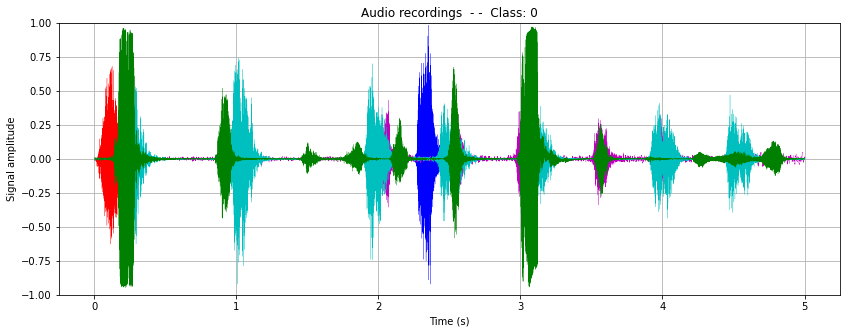

In [13]:
fig=plt.figure(figsize=(14,5))

colors=['b','r','m','c','g','k','y', 'grey', 'c', 'm', 'r' ]
for j in range(5) :

    plt.plot(time_vector, audio_data[j], color=colors[j],linewidth=0.25)


plt.ylim(-1, 1)
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude')
plt.title('Audio recordings  - -  Class: '+str(labels[j]))
plt.grid()

<span style="color:#4169E1"> In this dog barking audio clips subset [0:5], one audio clip consists of 4.5 s of silence and one 0.5 s dog barking occurence. 
Other audio clips consist of several occurences of the same phenomenon. <br> We will reduce the length of ALL audio clips in all classes to 1.25s. For retaining the clock tick fundamental frequency= 1 Hz.  

#### Plot various audio signals 

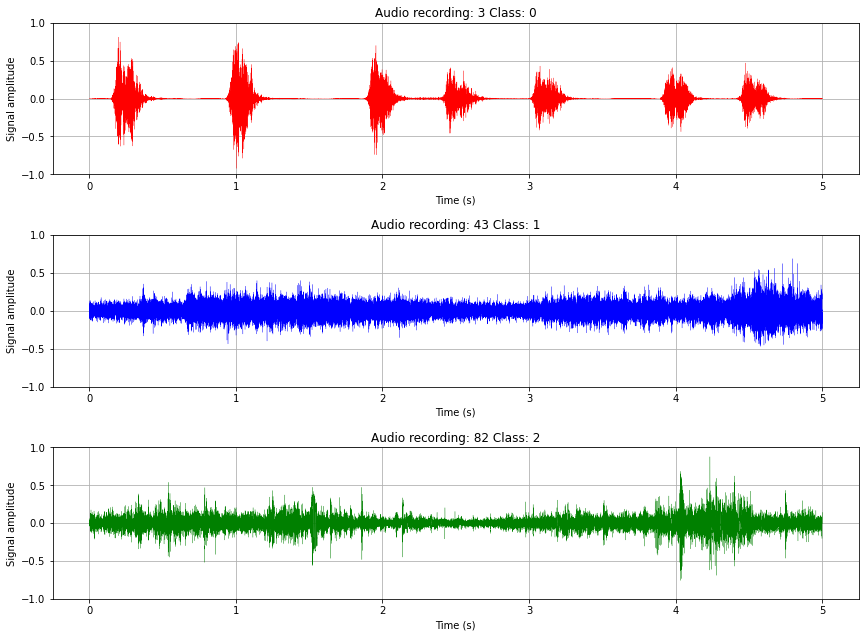

In [14]:
fig=plt.figure(figsize=(14,10))


ax = fig.add_subplot(3, 1, 1)
#  RGBA tuple  ((0,1,0,1))    Alpha is ytransparecy from 0 to 1   
plt.plot(time_vector,audio_data[ind[0]][0:len(time_vector)],'r',linewidth=0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
plt.title('Audio recording: '+str(ind[0])+' Class: '+str(labels[ind[0]]))
ax.grid()
#plt.show()

ax = fig.add_subplot(3, 1, 2)
#  RGBA tuple  ((0,1,0,1))    Alpha is ytransparecy from 0 to 1   
plt.plot(time_vector,audio_data[ind[1]][0:len(time_vector)],'b',linewidth=0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
plt.title('Audio recording: '+str(ind[1])+' Class: '+str(labels[ind[1]]))
ax.grid()
#plt.show()

ax = fig.add_subplot(3, 1, 3)
#  RGBA tuple  ((0,1,0,1))    Alpha is ytransparecy from 0 to 1   
plt.plot(time_vector,audio_data[ind[2]][0:len(time_vector)],'g',linewidth=0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
plt.title('Audio recording: '+str(ind[2])+' Class: '+str(labels[ind[2]]))
ax.grid()

# set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

### Reducing the size of audio signals 

<span style="color:#4169E1"> We split all audio clips in 1.25 s frames. With overlap (step= st). And we select the frame with the highest power for each audio clip. <br>
    <b>Note:</b> the dot product frames[i]\*frames[i].T is proportional to the audio signal power. 

In [15]:
from scipy import signal
from skimage import util

In [16]:
sub_sequence= fs*1.25    #  1.25 seconds of signal ! 
st=400 #  samples for sliding the window ith overlap  
audio_data_red = []

print('running...   ')
print('  ')
reduc_audio_start= time.time() 

for i in range (0,400):
    if i%99 == 0:
        print(i)
        
    frames = util.view_as_windows(audio_data[i], window_shape=(sub_sequence,), step=st) 
    optim_frame_index= np.dot(frames,frames.T).diagonal().argmax()     
        
    audio_data_red.append(frames[optim_frame_index]/np.max(frames[optim_frame_index]))   

reduc_audio_end= time.time()   
print('  ')
print(f'Audio clip size reduction computing time (s) {reduc_audio_end - reduc_audio_start:.2f}')

running...   
  
0
99
198
297
396
  
Audio clip size reduction computing time (s) 61.24


In [17]:
np.shape(frames), np.shape(audio_data_red)
time_red=len(audio_data_red[0])
time_red

27562

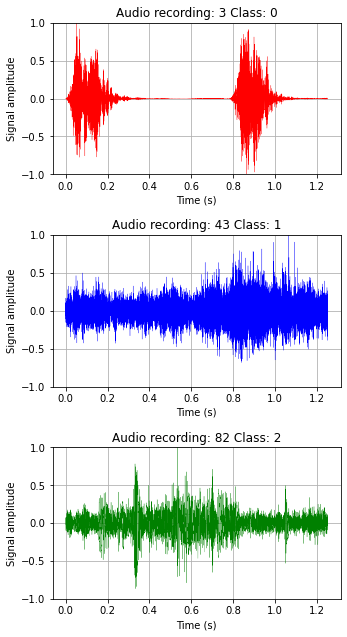

In [18]:
#save_path='dog_time.jpg'
fig=plt.figure(figsize=(5,10))
#plt.title('Figure 8 Torus')

ax = fig.add_subplot(3, 1, 1)
#  RGBA tuple  ((0,1,0,1))    Alpha is transparency from 0 to 1   
plt.plot(np.arange(time_red)/fs,audio_data_red[ind[0]][0:time_red],'r',linewidth=0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
plt.title('Audio recording: '+str(ind[0])+' Class: '+str(labels[ind[0]]))
ax.grid()
#plt.show()

ax = fig.add_subplot(3, 1, 2)
#  RGBA tuple  ((0,1,0,1))    Alpha is ytransparecy from 0 to 1   
plt.plot(np.arange(time_red)/fs,audio_data_red[ind[1]][0:time_red],'b',linewidth=0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
plt.title('Audio recording: '+str(ind[1])+' Class: '+str(labels[ind[1]]))
ax.grid()
#plt.show()


ax = fig.add_subplot(3, 1, 3)
#  RGBA tuple  ((0,1,0,1))    Alpha is ytransparecy from 0 to 1   
plt.plot(np.arange(time_red)/fs,audio_data_red[ind[2]][0:time_red],'g',linewidth=0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
plt.title('Audio recording: '+str(ind[2])+' Class: '+str(labels[ind[2]]))
ax.grid()

# set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

In [19]:
time_vector_red=(1/fs)*np.arange(len(audio_data_red[0]))  # time (s) vector 

## Wavelet Transforms 

<span style="color:#4169E1"> At the moment we are experimenting wavelets selection. We leave the ugly "if" statements, we will build a list of sound type/wavelet.  <br><br> 

<span style="color:#4169E1"> 
    
- <b>'morl'</b> is the default. <br>
- <b>'cgau5'</b> and <b>'gaus5'</b> do a good job at discriminating sea waves from rain.  <br>
- <b>'mexh'</b> enhances the detection of impulse and gives a strong signal with narrow band harmonics. <br> 
'mexh' did not help much with clock tick: label=4. We applied default wavelet transform selection (morl). 

- Class = 01-Dogbark, Label = 0
- Class = 02-Rain, Label = 1
- Class = 03-Seawaves, Label = 2
- Class = 04-Babycry, Label = 3
- Class = 05-Clocktick, Label = 4
- Class = 06-Personsneeze, Label = 5
- Class = 07-Helicopter, Label = 6
- Class = 08-Chainsaw, Label = 7
- Class = 09-Rooster, Label = 8
- Class = 10-Firecrackling, Label = 9

In [20]:
wavlist = pywt.wavelist(kind='continuous')
print('Continuous wavelets:', wavlist)
print('Continuous wavelets set includes real and complex wavelets')

Continuous wavelets: ['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']
Continuous wavelets set includes real and complex wavelets


In [21]:
import numpy as np
import pywt
dt = time_vector_red[1] - time_vector_red[0]
frequences = pywt.scale2frequency('cmor1.5-1.0', [1,128]) / dt
frequences

array([22050.      ,   172.265625])

In [22]:
# continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
#waveletname='morl'
#waveletname='mexh'
#waveletname='cgau2' # complex
#waveletname='morl' # complex
waveletname='cmor1.5-1.0' # complex
#waveletname='gaus5'
wavelet_mat_mag=[]
wavelet_mat_phas=[]
scales = range(1,129)
dt = time_vector_red[1] - time_vector_red[0]
#scale = tfrequency2scale('cmor1.5-1.0', frequencies)
#scale

ind=[3, 43, 82, 122, 165, 208, 245, 284, 326, 365 ]
lw=-1
for i in ind:
    lw=lw+1
 
    
    #if lw==4 or lw==6 : 
    #if lw==4 or lw==6 or lw==7 or lw==9 : 
    #    waveletname='cgau8'
    if lw==1 or lw==2 :  #or lw==9 : 
        waveletname='cgau5'
        
    if lw==9 : 
        waveletname='cgau1'       
        
    [coefficients, frequencies] = pywt.cwt(audio_data_red[i],scales, waveletname, dt)
    #pwr = (abs(coefficients))**2
    #pwr = np.clip(pwr, -25, 9)
    #pwr = np.log2(abs(coefficients)**2+1e-12)   # coefficients are complex with 'cgau5' 
    #pwr = 10*np.log10(abs(coefficients)**2+1e-12)   # coefficients are complex with 'cgau5' 
    #pwr = np.clip(pwr, -40, 5)
    
    scal_mag=20*np.log10(abs(coefficients) + 1e-12)
    #scal_mag = np.clip(scal_mag, -30, 5)
    scal_phas=np.unwrap(np.angle(coefficients))
    #scal_phas=np.angle(coefficients)
    #if lw==1 or lw==2 or lw==9: 
    #    scal_phas = np.clip(scal_phas, -5000, 0)
    #else :
    #    scal_phas = np.clip(scal_phas, 0, 5000)
    #scal_phas = np.clip(scal_phas, -3000, 3000)
    
    wavelet_mat_mag.append(scal_mag) 
    wavelet_mat_phas.append(scal_phas) 
    #mag_cwt=abs(coefficients)
    #wavelet_mat.append(mag_cwt) 
    #waveletname='morl'  # defult wavelet type
    waveletname='cmor1.5-1.0' # complex
#wavelet_mat=np.array(wavelet_mat)

wavelet_mat_mag=np.array( wavelet_mat_mag)
wavelet_mat_phas=np.array( wavelet_mat_phas)

In [23]:
len(scales)

128

In [24]:
step_time=216 #  for time dimension = 128 
sub_time=time_vector_red[0:time_red:step_time]  # We reduce the size of the time vector !  We will lose details on scalograms ! 
#The step, here 100 depends on fs. st=100 means we downsample time every:  100/fs  second. If fs=44.1 kHz: 2.2 ms   

In [25]:
np.shape(wavelet_mat_mag),  np.shape(sub_time)

((10, 128, 27562), (128,))

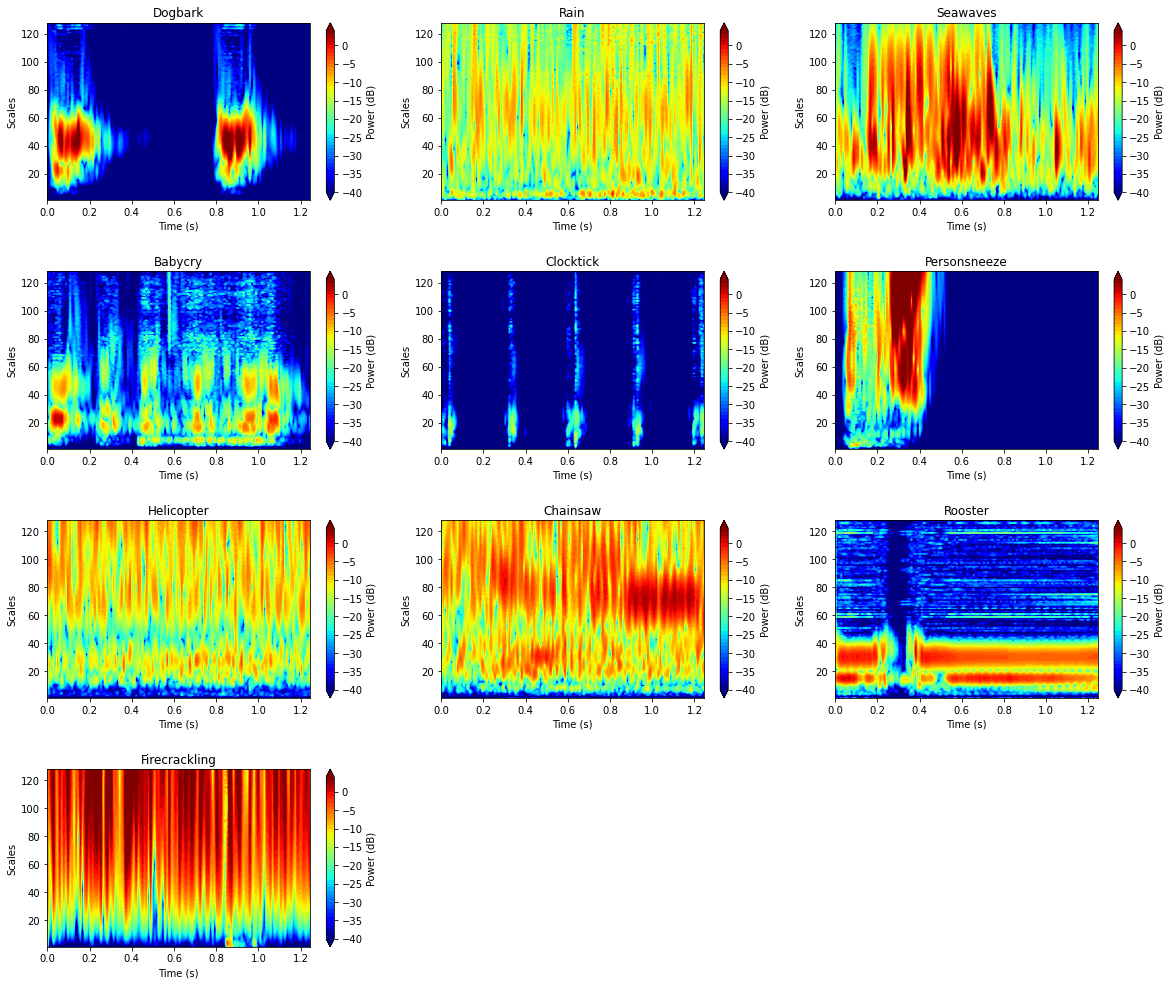

In [26]:
list_soundtype=['Dogbark', 'Rain', 'Seawaves', 'Babycry',  'Clocktick', 'Personsneeze',\
                                             'Helicopter', 'Chainsaw',  'Rooster',  'Firecrackling' ]        

period = 1. / frequencies

contourlevels = np.arange(-40,5,1)
cmap= 'jet'
#-----------------
fig=plt.figure(figsize=(20,17))
plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    #wspace=0.5,
                    hspace=0.4)

for ii in range(3) :
    for jj in range(3) :
        k=3*ii + jj
        
        ax = fig.add_subplot(4, 3, k+1)
        img= ax.contourf(sub_time, scales,\
                         #np.log2(wavelet_mat[k,:,0:time_red:step_time]+1e-12),\
                         wavelet_mat_mag[k,:,0:time_red:step_time],

                         contourlevels, 
                         extend='both', 
                         cmap=cmap) 
        
        #fig.colorbar(img, ax=ax, format='%+2.0f Mag^(0.5)')
        cbar=fig.colorbar(img, ax=ax)
        cbar.set_label('Power (dB)')
        ax.set(title=list_soundtype[k])
        ax.set_xlabel('Time (s)')
        #ax.set_ylabel('Period')
        #ax.set_ylabel('Frequencies')
        ax.set_ylabel('Scales')

ax = fig.add_subplot(4, 3, 10)
img = ax.contourf(sub_time, scales, 
                  #np.log2(wavelet_mat[9,:,0:time_red:step_time]+1e-12),\
                  wavelet_mat_mag[9,:,0:time_red:step_time],

                  contourlevels, 
                  extend='both',cmap=cmap)
#cbar=fig.colorbar(img, ax=ax, format='%+2.0f)
cbar=fig.colorbar(img, ax=ax)
cbar.set_label('Power (dB)')
ax.set(title=list_soundtype[9])
ax.set_xlabel('Time (s)')
#ax.set_ylabel('Period')
#ax.set_ylabel('Frequencies')
ax.set_ylabel('Scales')

plt.show()


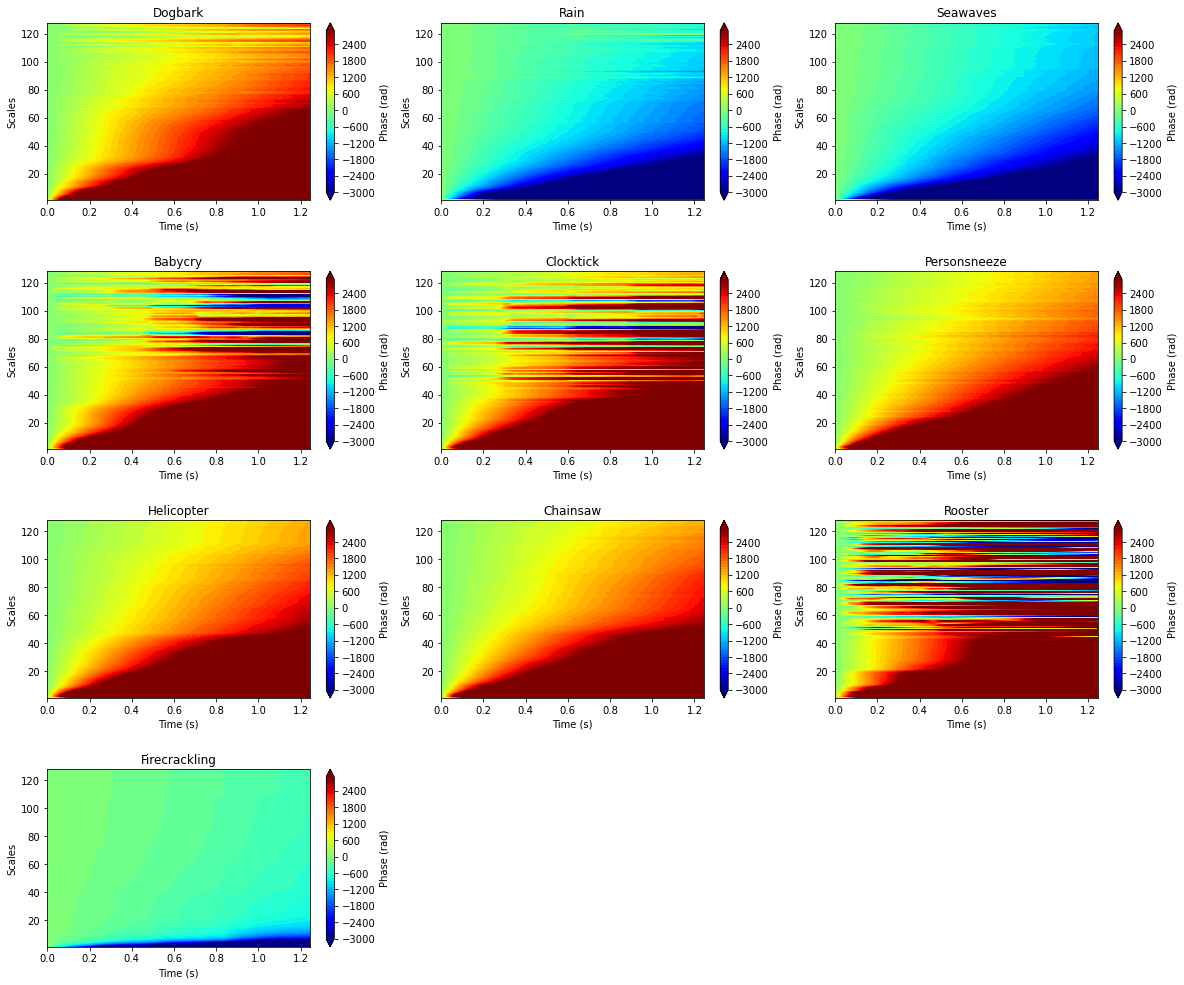

In [27]:
list_soundtype=['Dogbark', 'Rain', 'Seawaves', 'Babycry',  'Clocktick', 'Personsneeze',\
                                             'Helicopter', 'Chainsaw',  'Rooster',  'Firecrackling' ]        

period = 1. / frequencies
#contourlevels = np.arange(-25,9,1)
contourlevels = np.arange(-3000,3000,100)
cmap= 'jet'
#-----------------
fig=plt.figure(figsize=(20,17))
plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    #wspace=0.5,
                    hspace=0.4)

for ii in range(3) :
    for jj in range(3) :
        k=3*ii + jj
        
        ax = fig.add_subplot(4, 3, k+1)
        img= ax.contourf(sub_time, scales,\
                         #np.log2(wavelet_mat[k,:,0:time_red:step_time]+1e-12),\
                         wavelet_mat_phas[k,:,0:time_red:step_time],

                         contourlevels, 
                         extend='both', 
                         cmap=cmap) 
        
        #fig.colorbar(img, ax=ax, format='%+2.0f Mag^(0.5)')
        cbar=fig.colorbar(img, ax=ax)
        cbar.set_label('Phase (rad)')
        ax.set(title=list_soundtype[k])
        ax.set_xlabel('Time (s)')
        #ax.set_ylabel('Period')
        #ax.set_ylabel('Frequencies')
        ax.set_ylabel('Scales')

ax = fig.add_subplot(4, 3, 10)
img = ax.contourf(sub_time, scales, 
                  #np.log2(wavelet_mat[9,:,0:time_red:step_time]+1e-12),\
                  wavelet_mat_phas[9,:,0:time_red:step_time],

                  contourlevels, 
                  extend='both',cmap=cmap)
#cbar=fig.colorbar(img, ax=ax, format='%+2.0f)
cbar=fig.colorbar(img, ax=ax)
cbar.set_label('Phase (rad)')
ax.set(title=list_soundtype[9])
ax.set_xlabel('Time (s)')
#ax.set_ylabel('Period')
#ax.set_ylabel('Frequencies')
ax.set_ylabel('Scales')

plt.show()

<span style="color:#4169E1"> We create wavelet transforms for the 400 audio clips. <br>

In [28]:
print('running...   ')
print('  ')

waveletname='cmor1.5-1.0' # complex
cwt_audio_start= time.time()   

data_cwt_mag= np.ndarray(shape=(len(audio_data_red), len(scales), len(sub_time)))
data_cwt_phas= np.ndarray(shape=(len(audio_data_red), len(scales), len(sub_time)))

for ii in range(0,len(audio_data_red)):

    if ii % 99 == 0:
        print(ii)
    

    if labels[ii]==1 or labels[ii]==2 :  # or labels[ii]==9 : 
        waveletname='cgau5'
        
    if labels[ii]==9 :
        waveletname='cgau1'
    
    [coefficients, frequencies] = pywt.cwt(audio_data_red[ii], scales, waveletname, dt)
    
    #mag_cwt=abs(coefficients)  # Magnitude
    #data_cwt[ii,:,:] = mag_cwt[:,0:time_red:step_time]   # reduction of Data ! 
    #pwr = abs(coefficients)**2   # Coeff Power 
    #pwr = np.log2(abs(coefficients)**2+1e-12)   # coefficients are complex with 'cgau5' 
    #pwr = np.clip(pwr, -20, 10)
    #pwr = 10*np.log10(abs(coefficients)**2+1e-12)   # coefficients are complex with 'cgau5' 
    #pwr = np.clip(pwr, -40, 5)
    
    scal_mag=20*np.log10(abs(coefficients) + 1e-12)
    scal_mag = np.clip(scal_mag, -40, 5)
    
    scal_phas=np.unwrap(np.angle(coefficients))
    #scal_phas=np.angle(coefficients)
    scal_phas = np.clip(scal_phas, -3000, 3000)
    
    data_cwt_mag[ii,:,:] = scal_mag[:,0:time_red:step_time]   # reduction of Data ! 
    data_cwt_phas[ii,:,:] = scal_phas[:,0:time_red:step_time]   # reduction of Data ! 
    #-----------------
    #waveletname='morl'
    waveletname='cmor1.5-1.0' # complex
  
    
cwt_audio_end= time.time()   
print('  ')
print(f'Wavelet Transform computing time (s) {cwt_audio_end - cwt_audio_start:.2f}')

running...   
  
0
99
198
297
396
  
Wavelet Transform computing time (s) 1957.41


In [29]:
np.shape(data_cwt_mag), np.shape(data_cwt_phas), np.shape(audio_data_red)

((400, 128, 128), (400, 128, 128), (400, 27562))

In [30]:
melspec = []
hp_l= step_time 
n_m = 128
NFFT=1024*2  # high definition. Remember 1 sec audio signal <--->  fs= 44100 points  or  fs= 22050 points 
trunc_mel= 128  # truncation number of mels filters 

In [31]:
melspec = []
#hp_l= 216
#n_m = 128
NFFT=1024*2  # high definition. Remember 1 sec audio signal <--->  fs= 44100 points  or  fs= 22050 points 
trunc_mel= 256  # truncation number of mels filters 


ind=[3, 43, 82, 122, 165, 208, 245, 284, 326, 365 ]

for i in ind:
    #print(i)
    mel_feature = librosa.feature.melspectrogram(y=audio_data_red[i],sr=fs,
                                          n_fft= NFFT, 
                                          hop_length= hp_l, 
                                          win_length= NFFT, 
                                          window='hann', center=True, power=2, pad_mode='constant', n_mels=n_m)
    
    pwr = librosa.power_to_db(mel_feature, ref=1e-3)
    pwr= np.clip(pwr, -10, 40)
    melspec.append(pwr)  

melspec =np.array(melspec)

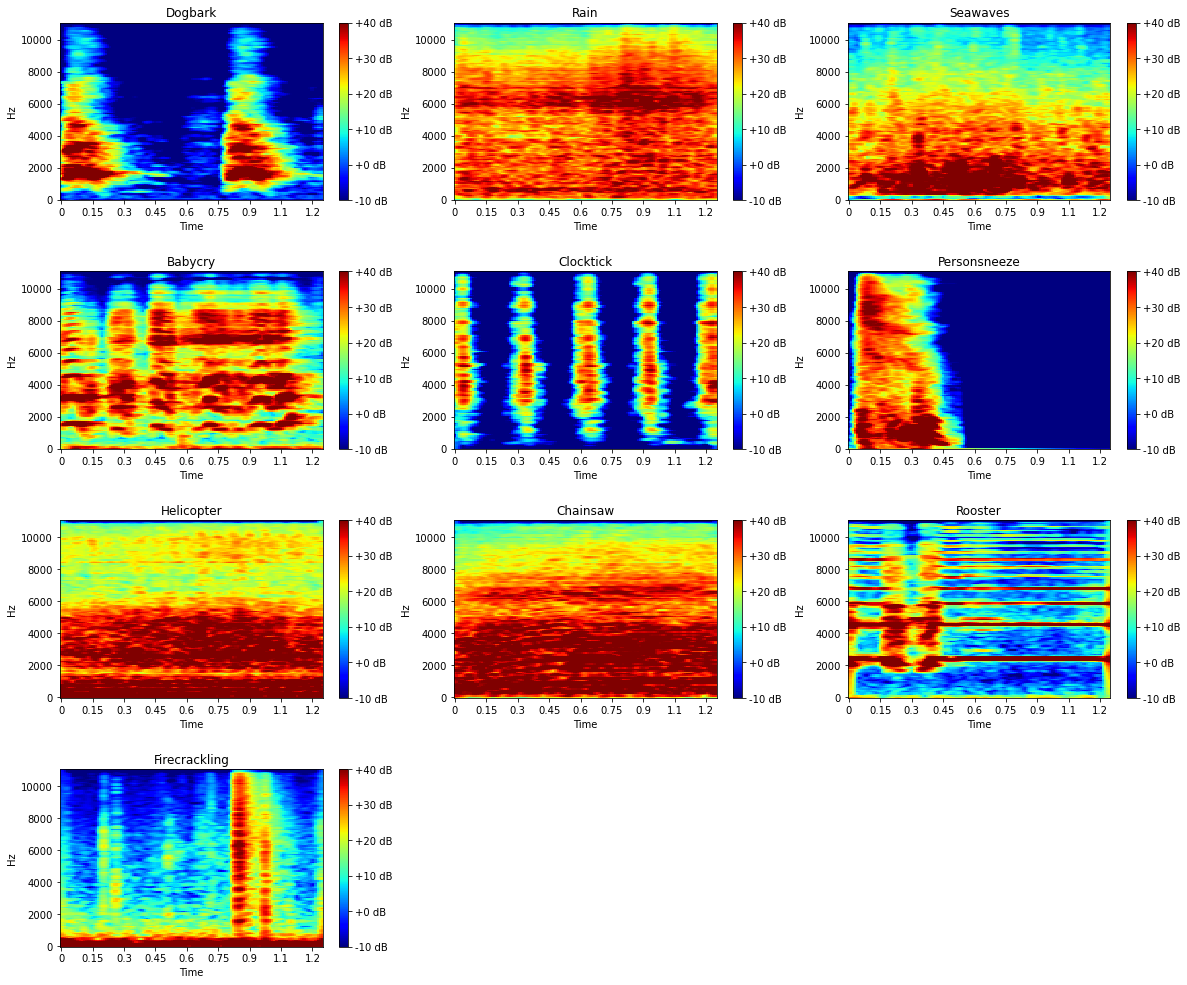

In [32]:
list_soundtype=['Dogbark', 'Rain', 'Seawaves', 'Babycry',  'Clocktick', 'Personsneeze',\
                                             'Helicopter', 'Chainsaw',  'Rooster',  'Firecrackling' ]        

fig=plt.figure(figsize=(20,17))
plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    #wspace=0.5,
                    hspace=0.4)

for ii in range(3) :
    for jj in range(3) :
        k=3*ii + jj
        ax = fig.add_subplot(4, 3, k+1)
        mels_dB=np.array(melspec[k,0:trunc_mel,:])
        img=librosa.display.specshow(mels_dB, y_axis='linear',   hop_length=hp_l, sr=fs,  
                         x_axis='time',  ax=ax, cmap='jet')
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        #ax.set(title='Mel-frequency spectrogram'+list_soundtype[k])
        ax.set(title=list_soundtype[k])
        
        
ax = fig.add_subplot(4, 3, 10)
mels_dB=np.array(melspec[9,0:trunc_mel,:])
img=librosa.display.specshow(mels_dB, y_axis='linear',   hop_length=hp_l, sr=fs,  
                         x_axis='time',  ax=ax, cmap='jet')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title=list_soundtype[9])

plt.show()

In [33]:
melspectrogram = []
# All parameters defined already - NO parameter update here !!!  
print('running...   ')
print('  ')
melspec_audio_start= time.time() 

for i in range (0,400):
    if i%99 == 0:
        print(i)
    mel_feat = librosa.feature.melspectrogram(y=audio_data_red[i],sr=fs,
                                          n_fft= NFFT, 
                                          hop_length= hp_l, 
                                          win_length= NFFT, 
                                          window='hann', 
                                          center=True, 
                                          power=2, pad_mode='constant', n_mels=n_m)
    
    mel_feat=mel_feat[0:trunc_mel,:]  # Truncation number of mel filters 
    pwr = librosa.power_to_db(mel_feat, ref=1e-3)
    #pwr= np.clip(pwr, -10, 40)
    pwr=pwr.reshape(-1,1)
    melspectrogram.append(pwr)  

melspectrogram =np.array(melspectrogram) 


melspec_audio_end= time.time()   
print('  ')
print(f'mel-spectrum audio computing time (s) {melspec_audio_end - melspec_audio_start:.2f}') 

running...   
  
0
99
198
297
396
  
mel-spectrum audio computing time (s) 18.80


<span style="color:#4169E1">  We represent scalograms as 400 vectors for <b>scaling/normalization</b>. 
We will reshape the 400 vectors into 400 "image" matrices (n_scales,-1) for Deep Learning. 
For CNN deep learning, the standard normalizer seems to work better than the minmaxscaler. To be confirmed.  

In [34]:
melspectrogram.shape

(400, 16384, 1)

In [35]:
# Normalization type I: [0,1]

In [36]:
# Normalization type II - Better ! 

In [37]:
from sklearn import preprocessing
#-----------------------------------------------------------------------
data_cwt_mag_vec=data_cwt_mag.reshape(400,-1)
data_cwt_phas_vec=data_cwt_phas.reshape(400,-1)
#------------------------------------------------------------------------
transform = preprocessing.StandardScaler()
#------------------------------------------------------------------------
normalized_data_cwt_mag_vec= transform.fit_transform(data_cwt_mag_vec)
normalized_data_cwt_phas_vec= transform.fit_transform(data_cwt_phas_vec)

In [38]:
melspectro=melspectrogram.reshape(400,-1)
transform = preprocessing.StandardScaler()
normalized_melspectro= transform.fit_transform(melspectro)

In [39]:
 np.min(data_cwt_mag_vec), np.max(data_cwt_mag_vec), np.min(data_cwt_phas_vec), np.max(data_cwt_phas_vec)

(-40.0, 5.0, -3000.0, 3000.0)

In [40]:
np.min(normalized_data_cwt_mag_vec), np.max(normalized_data_cwt_mag_vec), np.min(normalized_data_cwt_phas_vec), np.max(normalized_data_cwt_phas_vec)

(-1.6739003492578857,
 8.709027935402505,
 -11.560176800192895,
 13.256601716496618)

In [41]:
np.min(normalized_melspectro), np.max(normalized_melspectro)

(-5.090835, 4.0177603)

In [42]:
data_cwt_global = np.ndarray(shape=(400, len(scales)*np.shape(data_cwt_mag)[2], 3))
 
for ii in range(0,400):
    if ii % 99 == 0:
        print(ii)

    data_cwt_global[ii,:,0]= normalized_data_cwt_mag_vec[ii,:]
    #data_cwt_global[ii,:,1]= normalized_melspectro[ii,:]
    data_cwt_global[ii,:,1]= normalized_data_cwt_phas_vec[ii,:]
    data_cwt_global[ii,:,2]= normalized_melspectro[ii,:]
   # 

0
99
198
297
396


In [43]:
np.shape(normalized_data_cwt_mag_vec)

(400, 16384)

In [44]:
labels=np.array(labels,dtype=int)
#labels

## Convolutional Neural Network 

<span style="color:#4169E1"> Normalized Scalograms are 2D-arrays (matrices). We reshape accordingly after normalization. 

In [45]:
features_cwt_CNN = np.reshape(data_cwt_global,(-1,len(scales), np.shape(data_cwt_mag)[2],3))
features_cwt_CNN.shape

(400, 128, 128, 3)

In [46]:
ind=[3, 43, 82, 122, 165, 208, 245, 284, 326, 365 ]

Text(0.5, 1.0, 'Sea Waves - Mel spectrogram')

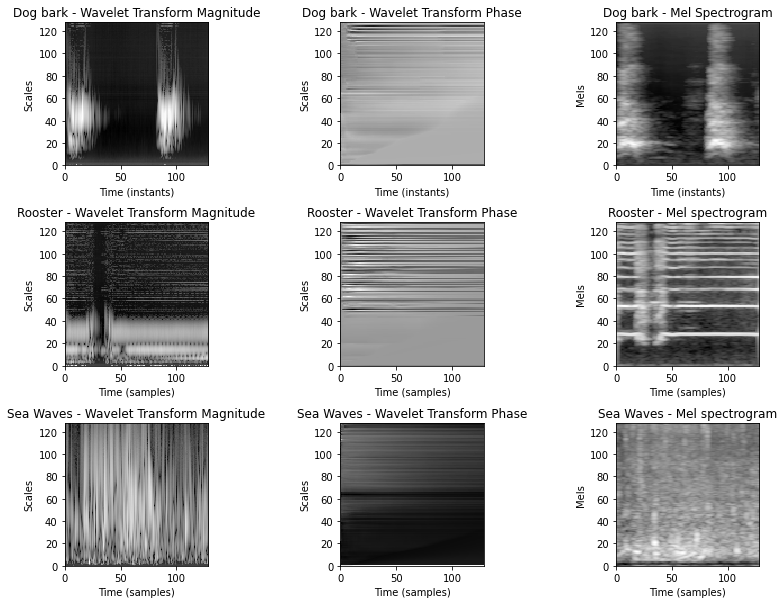

In [47]:
#plt.imshow(sub_time, scales, features_cwt_CNN[122,::-1,:,0] ,cmap='gray')
fig=plt.figure(figsize=(14,10))

plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    #wspace=0.5,
                    hspace=0.4)

ax = fig.add_subplot(3, 3, 1)
plt.imshow(features_cwt_CNN[3,::-1,:,0] ,cmap='gray',interpolation='none', extent=[0,np.shape(data_cwt_mag)[2],0,len(scales)])
ax.set_xlabel('Time (instants)')
ax.set_ylabel('Scales')
ax.set_title('Dog bark - Wavelet Transform Magnitude')
ax = fig.add_subplot(3, 3, 2)
#---
plt.imshow(features_cwt_CNN[3,::-1,:,1] ,cmap='gray',interpolation='none', extent=[0,np.shape(data_cwt_mag)[2],0,len(scales)])
ax.set_xlabel('Time (instants)')
ax.set_ylabel('Scales')
ax.set_title('Dog bark - Wavelet Transform Phase')
#---
ax = fig.add_subplot(3, 3, 3)
plt.imshow(features_cwt_CNN[3,::-1,:,2] ,cmap='gray',interpolation='none', extent=[0,np.shape(data_cwt_mag)[2],0,len(scales)])
ax.set_xlabel('Time (instants)')
ax.set_ylabel('Mels')
ax.set_title('Dog bark - Mel Spectrogram')
#
#-------
#
ax = fig.add_subplot(3, 3, 4)
plt.imshow(features_cwt_CNN[326,::-1,:,0] ,cmap='gray',interpolation='none', extent=[0,np.shape(data_cwt_mag)[2],0,len(scales)])
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Scales')
ax.set_title('Rooster - Wavelet Transform Magnitude')
#---
ax = fig.add_subplot(3, 3, 5)
plt.imshow(features_cwt_CNN[326,::-1,:,1] ,cmap='gray',interpolation='none', extent=[0,np.shape(data_cwt_mag)[2],0,len(scales)])
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Scales')
ax.set_title('Rooster - Wavelet Transform Phase')
#---
ax = fig.add_subplot(3, 3, 6)
plt.imshow(features_cwt_CNN[326,::-1,:,2] ,cmap='gray',interpolation='none', extent=[0,np.shape(data_cwt_mag)[2],0,len(scales)])
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Mels')
#ax.set_title('Rooster - Wavelet Transform Phase')
ax.set_title('Rooster - Mel spectrogram')
#
#-----
#
ax = fig.add_subplot(3, 3, 7)
plt.imshow(features_cwt_CNN[82,::-1,:,0] ,cmap='gray',interpolation='none', extent=[0,np.shape(data_cwt_mag)[2],0,len(scales)])
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Scales')
ax.set_title('Sea Waves - Wavelet Transform Magnitude')
#----
ax = fig.add_subplot(3, 3, 8)
plt.imshow(features_cwt_CNN[82,::-1,:,1] ,cmap='gray',interpolation='none', extent=[0,np.shape(data_cwt_mag)[2],0,len(scales)])
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Scales')
ax.set_title('Sea Waves - Wavelet Transform Phase')
#----
ax = fig.add_subplot(3, 3, 9)
plt.imshow(features_cwt_CNN[82,::-1,:,2] ,cmap='gray',interpolation='none', extent=[0,np.shape(data_cwt_mag)[2],0,len(scales)])
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Mels')
#ax.set_title('Sea Waves - Wavelet Transform Phase')
ax.set_title('Sea Waves - Mel spectrogram')

In [48]:
ylabels=keras.utils.to_categorical(labels, num_classes=10, dtype='float32')

In [49]:
ylabels[41]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

<span style="color:#4169E1"> Train/Test split: 80/20%. <br>
We shuffle the dataset and keep the same <code>random_state</code> for all runs when optimizing CNN parameters <br> And we stratify the sets based on labels. In this case, in both sets, we should have the same number of features/labels in each sound class.     

In [50]:
(train_X,test_X,train_y,test_y)= train_test_split(features_cwt_CNN, ylabels, test_size=0.2, stratify=ylabels, random_state=5)

In [51]:
np.shape(train_X), np.shape(train_y), np.shape(test_X), np.shape(test_y)

((320, 128, 128, 3), (320, 10), (80, 128, 128, 3), (80, 10))

In [52]:
train_X.shape[1:]

(128, 128, 3)

##### <b> CNN Parameters: </b>

<span style="color:#4169E1"> Quick discussion about parameters:

<span style="color:#4169E1">
    
- number of layers: 5 hidden layers.
- number of neurons per layers: generally we go with $2^n$ nodes per increasing number of layer. We started with small numbers and optimized the number of nodes and layers. 32, 64, 128, 256, 256 proved sufficient.   
- "image" matrices are 128x128 grayscale images. Still relatively small. (3,3) filters are sufficient. We let Stride and convolution Dilation rate at default values: (1,1). 
- optimizer: we tested Stochastic Gradient Descent (SGD) and Adam with different parameters. Adam was always superior. AMSGrad option may have further improved convergence.  
- overfitting was an issue initially: drop-out, with probability threshold between 0.1 and 0.2 prevented overfitting while converging close to maximum accuracy. With current implementation no overfitting occurs (hence no drop-out).   
- activation functions: both "ReLU" or "LeakyReLU (alpha:0.1-0.2") work. A slight advantage with ReLU. 

In [68]:
from keras.layers import LeakyReLU

model = Sequential()
#
model.add(Conv2D(32, (3, 3), dilation_rate=(1,1), input_shape=train_X.shape[1:]))
#model.add(Conv2D(64, (5, 5), dilation_rate=(1,1), input_shape=train_X.shape[1:]))
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))
#
#
model.add(Conv2D(64, (3, 3), dilation_rate=(1,1)))
#model.add(Conv2D(64, (5, 5), dilation_rate=(1,1))
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))


#model.add(Conv2D(256, (3, 3),dilation_rate=(1,1) )   )
model.add(Conv2D(128, (3, 3),dilation_rate=(1,1) )   )
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))
#
#model.add(Conv2D(512, (3, 3), dilation_rate=(1,1)))
model.add(Conv2D(256, (3, 3),dilation_rate=(1,1) )   )
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))
#
#---- fully connected layer
model.add(Flatten())      # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256))  
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.2))
#model.add(Dropout(0.1))

#--- Softmax classifier
#
model.add(Dense(10))
model.add(Activation('softmax'))
#------ Otimizers
opt=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    amsgrad=True,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    name='Adam')
#sgd = optimizers.SGD(learning_rate=0.0001, decay=1e-5, momentum=0.8, nesterov=True)
#sgd = optimizers.SGD(learning_rate=0.001, decay=1e-3, momentum=0.8, nesterov=True)
sgd = optimizers.SGD(learning_rate=0.00025, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              #optimizer=sgd,
              optimizer=opt,
              metrics=['accuracy'])

In [69]:
accuracy_threshold=0.98

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > accuracy_threshold):   
            print("\nReached %2.2f%% accuracy, we stop training!!" %(accuracy_threshold*100))   
            self.model.stop_training = True

In [70]:
custom_early_stopping = myCallback()

In [71]:
history = model.fit(
    train_X, 
    train_y, 
    epochs=40, 
    steps_per_epoch=len(train_X)//16,
    #validation_split=0.2, 
    validation_data=(test_X, test_y),
    batch_size=10, 
    #verbose=2,
    callbacks=[custom_early_stopping]
)

Epoch 1/40
20/20 [==============================] - 15s 601ms/step - loss: 2.0601 - accuracy: 0.2600 - val_loss: 1.6205 - val_accuracy: 0.5625
Epoch 2/40
20/20 [==============================] - 13s 669ms/step - loss: 1.2510 - accuracy: 0.5900 - val_loss: 0.8258 - val_accuracy: 0.6375
Epoch 3/40
20/20 [==============================] - 13s 633ms/step - loss: 0.8436 - accuracy: 0.6450 - val_loss: 0.6241 - val_accuracy: 0.6750
Epoch 4/40
20/20 [==============================] - 15s 747ms/step - loss: 0.7746 - accuracy: 0.6650 - val_loss: 0.4909 - val_accuracy: 0.7875
Epoch 5/40
20/20 [==============================] - 15s 770ms/step - loss: 0.6382 - accuracy: 0.7300 - val_loss: 0.4639 - val_accuracy: 0.7875
Epoch 6/40
20/20 [==============================] - 14s 685ms/step - loss: 0.4458 - accuracy: 0.8400 - val_loss: 0.3373 - val_accuracy: 0.9000
Epoch 7/40
20/20 [==============================] - 12s 584ms/step - loss: 0.3987 - accuracy: 0.8450 - val_loss: 0.2820 - val_accuracy: 0.9125

In [71]:
test_loss, test_acc = model.evaluate(test_X, test_y) 

3/3 [==============================] - 1s 295ms/step - loss: 0.1094 - accuracy: 0.9875


In [73]:
predictions= model.predict(x=test_X, batch_size=10)

8/8 [==============================] - 2s 136ms/step


In [74]:
predictions=predictions + 1e-09

In [75]:
test_y=test_y+1e-09

In [76]:
list_sound=['DogBark', 'Rain', 'SeaWaves', 'BabyCry',  'ClockTick', 'PersonSneeze',\
                                             'Helico', 'Chainsaw',  'Rooster',  'FireCrackling' ] 

In [77]:
from sklearn.metrics import classification_report
print(classification_report(test_y.argmax(axis=1), predictions.argmax(axis=1), target_names= list_sound))

               precision    recall  f1-score   support

      DogBark       1.00      1.00      1.00         8
         Rain       0.89      1.00      0.94         8
     SeaWaves       1.00      0.88      0.93         8
      BabyCry       1.00      1.00      1.00         8
    ClockTick       1.00      1.00      1.00         8
 PersonSneeze       1.00      1.00      1.00         8
       Helico       1.00      1.00      1.00         8
     Chainsaw       1.00      1.00      1.00         8
      Rooster       1.00      1.00      1.00         8
FireCrackling       1.00      1.00      1.00         8

     accuracy                           0.99        80
    macro avg       0.99      0.99      0.99        80
 weighted avg       0.99      0.99      0.99        80



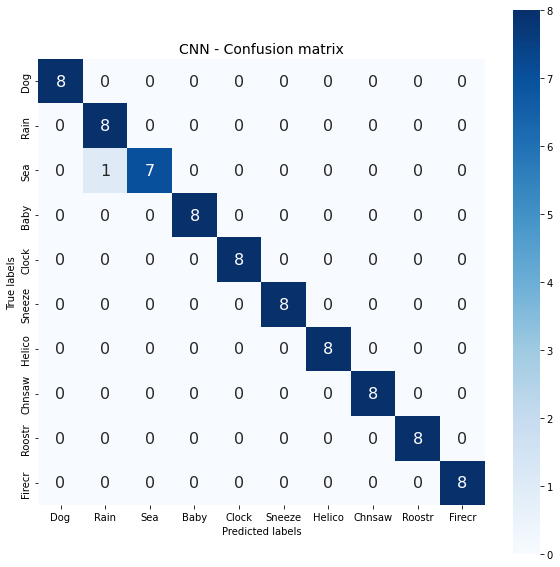

In [78]:
list_sound2=['Dog', 'Rain', 'Sea', 'Baby',  'Clock', 'Sneeze',\
                                             'Helico', 'Chnsaw',  'Roostr',  'Firecr' ] 
fig=plt.figure(figsize=(10,10))
plot_confusion_matrix(test_y.argmax(axis=1), predictions.argmax(axis=1),list_sound2)
plt.title("CNN - Confusion matrix", fontsize=14)
plt.savefig("CNN_Wavelet_ConfusionMatrix_figure01.png")
plt.show()

<span style="color:#4169E1">   There is some confusion: <br>
- in the non-stationary category resultng from vibration of tract, or nasal vibration:  dogbark, rooster, person sneeze... 
- in the impulsive noise category: clocktick and firecrackling.

We could improve this results, with higher definition mel-spectrogram. Or maybe high definition spectrograms. 

- Class = 01-Dogbark, Label = 0
- Class = 02-Rain, Label = 1
- Class = 03-Seawaves, Label = 2
- Class = 04-Babycry, Label = 3
- Class = 05-Clocktick, Label = 4
- Class = 06-Personsneeze, Label = 5
- Class = 07-Helicopter, Label = 6
- Class = 08-Chainsaw, Label = 7
- Class = 09-Rooster, Label = 8
- Class = 10-Firecrackling, Label = 9

In [80]:
def summarize_diagnostics(history):
 # plot loss
    acc = history.history['accuracy']
    epochs = range(len(acc))
    fig=plt.figure(figsize=(8,6))
    plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    #wspace=0.5,
                    hspace=0.4)
    
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(epochs, history.history['loss'], color='blue', label='Train')
    plt.plot(epochs, history.history['val_loss'], color='red', label='Test')
    plt.legend()
    plt.grid()
     # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(history.history['accuracy'], color='c', label='Train')
    plt.plot(history.history['val_accuracy'], color='crimson', label='Test')
    plt.legend()
    plt.grid()
     # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()

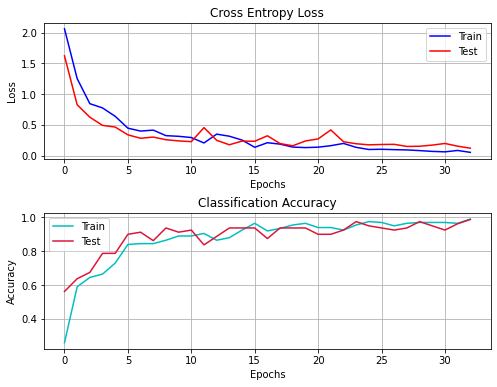

In [81]:
summarize_diagnostics(history)

In [82]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 activation_13 (Activation)  (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                  